In [ ]:
!pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 36.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=480baa9f38a1746b96b45e83d6a07d7d013032b81bb6cf6309a222b8a68b9469
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize_matplotlib


★★★ 第04回 P.41 課題（水平荷重）モデルを解析します ★★★

--- 1. 入力データ ---
節点: {1: (0.0, 0.0), 2: (1.5, np.float64(-0.8660254037844386)), 3: (2.0, 0.0)}
要素: {1: (1, 2), 2: (2, 3)}
E=1.0, A=1.0
荷重: {1: (0.0, 0.0), 2: (1.0, 0.0), 3: (0.0, 0.0)}
境界条件: {1: (True, True), 2: (False, False), 3: (True, True)}

--- 2. 要素剛性行列の計算とアセンブリ ---
要素 1 (節点 1-2): L=1.73, c=0.87, s=-0.50
要素 2 (節点 2-3): L=1.00, c=0.50, s=0.87

アセンブリ後の全体剛性行列 K_all (6x6):
 [[ 0.433 -0.25  -0.433  0.25   0.     0.   ]
 [-0.25   0.144  0.25  -0.144  0.     0.   ]
 [-0.433  0.25   0.683  0.183 -0.25  -0.433]
 [ 0.25  -0.144  0.183  0.894 -0.433 -0.75 ]
 [ 0.     0.    -0.25  -0.433  0.25   0.433]
 [ 0.     0.    -0.433 -0.75   0.433  0.75 ]]

--- 3. 境界条件の適用 ---
自由な自由度 (DOFs): [2, 3]
解くべき部分剛性方程式 K_ff:
 [[0.683 0.183]
 [0.183 0.894]]
対応する荷重ベクトル F_f: [1. 0.]

--- 4. 解析結果 (変位) ---
節点 1: U_1 =  0.0000000, V_1 =  0.0000000
節点 2: U_2 =  1.5490381, V_2 = -0.3169873
節点 3: U_3 =  0.0000000, V_3 =  0.0000000

--- 5. 解析結果 (部材軸力) ---
要素 1 (節点 1-2): 軸力 N =  0.866

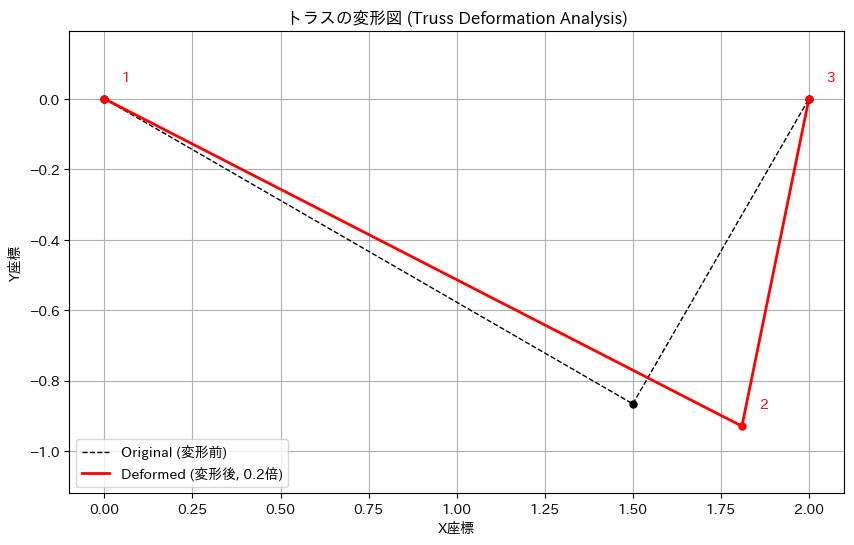

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib # Google Colabで日本語表示を有効化

def plot_truss(nodes, elements, U_all, scale_factor=1.0):
    """
    トラスの変形前と変形後を描画する関数 (可視化担当)

    Args:
        nodes (dict): 節点座標 {節点番号: (x, y)}
        elements (dict): 要素 {要素番号: (i端, j端)}
        U_all (np.array): 全変位ベクトル (解析結果)
        scale_factor (float): 変位の表示倍率
    """

    # 変形後の節点座標を計算
    nodes_deformed = {}
    for node_id, (x, y) in nodes.items():
        dof_x = (node_id - 1) * 2
        dof_y = (node_id - 1) * 2 + 1

        # 変位に変倍率を適用
        u = U_all[dof_x] * scale_factor
        v = U_all[dof_y] * scale_factor

        nodes_deformed[node_id] = (x + u, y + v)

    plt.figure(figsize=(10, 6))

    # 1. 変形前の構造を描画 (破線・黒)
    for el_id, (i, j) in elements.items():
        x = [nodes[i][0], nodes[j][0]]
        y = [nodes[i][1], nodes[j][1]]
        plt.plot(x, y, 'k--', linewidth=1.0, label='Original (変形前)' if el_id == 1 else "")

    # 2. 変形後の構造を描画 (実線・赤)
    for el_id, (i, j) in elements.items():
        x_def = [nodes_deformed[i][0], nodes_deformed[j][0]]
        y_def = [nodes_deformed[i][1], nodes_deformed[j][1]]
        plt.plot(x_def, y_def, 'r-', linewidth=2.0, label=f'Deformed (変形後, {scale_factor}倍)' if el_id == 1 else "")

    # 3. 節点を描画
    for node_id, (x, y) in nodes.items():
        plt.plot(x, y, 'ko', markersize=5) # 変形前の節点

    for node_id, (x_def, y_def) in nodes_deformed.items():
        plt.plot(x_def, y_def, 'ro', markersize=5) # 変形後の節点
        plt.text(x_def + 0.05, y_def + 0.05, f'{node_id}', color='red') # 節点番号


    plt.xlabel('X座標')
    plt.ylabel('Y座標')
    plt.title('トラスの変形図 (Truss Deformation Analysis)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal') # X軸とY軸のスケールを合わせる
    plt.show()


def solve_truss(nodes, elements, E, A, bcs, loads):
    """
    トラス構造解析を実行する関数 (計算担当)

    Args:
        nodes (dict): 節点座標
        elements (dict): 要素定義
        E (float): ヤング係数
        A (float): 断面積
        bcs (dict): 境界条件
        loads (dict): 荷重ベクトル

    Returns:
        U_all (np.array): 全変位ベクトル
        element_forces (dict): 要素ごとの軸力
    """

    # -----------------------------------------------------
    # 1. 入力データの確認 (メインから渡されたもの)
    # -----------------------------------------------------
    print("--- 1. 入力データ ---")
    print(f"節点: {nodes}")
    print(f"要素: {elements}")
    print(f"E={E}, A={A}")
    print(f"荷重: {loads}")
    print(f"境界条件: {bcs}\n")

    # -----------------------------------------------------
    # 2. 全体剛性行列 [K_all] の構築 (アセンブリ)
    # -----------------------------------------------------

    num_nodes = len(nodes)
    num_dofs = num_nodes * 2
    K_all = np.zeros((num_dofs, num_dofs))
    F_all = np.zeros(num_dofs)

    print("--- 2. 要素剛性行列の計算とアセンブリ ---")

    for el_id, (i, j) in elements.items():

        xi, yi = nodes[i]
        xj, yj = nodes[j]
        dx = xj - xi
        dy = yj - yi
        L = np.sqrt(dx**2 + dy**2)
        c = dx / L
        s = dy / L

        # 部材座標系の要素剛性行列 [k] (4x4)
        k_local = (E * A / L) * np.array([
            [ 1,  0, -1,  0],
            [ 0,  0,  0,  0],
            [-1,  0,  1,  0],
            [ 0,  0,  0,  0]
        ])

        # 座標変換マトリクス [R] (4x4)
        R_theta = np.array([
            [ c,  s],
            [-s,  c]
        ])
        R = np.zeros((4, 4))
        R[0:2, 0:2] = R_theta
        R[2:4, 2:4] = R_theta

        # [K'] = [R]^T [k] [R]
        K_global = R.T @ k_local @ R

        print(f"要素 {el_id} (節点 {i}-{j}): L={L:.2f}, c={c:.2f}, s={s:.2f}")

        # [K'] を [K_all] にアセンブリ
        dofs = [ (i-1)*2, (i-1)*2 + 1, (j-1)*2, (j-1)*2 + 1 ]
        for r in range(4):
            for col in range(4):
                K_all[dofs[r], dofs[col]] += K_global[r, col]

    for node_id, (Fx, Fy) in loads.items():
        F_all[(node_id-1)*2]     = Fx
        F_all[(node_id-1)*2 + 1] = Fy

    print(f"\nアセンブリ後の全体剛性行列 K_all ({num_dofs}x{num_dofs}):\n {np.round(K_all, 3)}")

    # -----------------------------------------------------
    # 3. 境界条件の適用と求解
    # -----------------------------------------------------

    free_dofs = []
    fixed_dofs = []
    for node_id, (x_fixed, y_fixed) in bcs.items():
        dof_x = (node_id - 1) * 2
        dof_y = (node_id - 1) * 2 + 1
        if x_fixed: fixed_dofs.append(dof_x)
        else: free_dofs.append(dof_x)
        if y_fixed: fixed_dofs.append(dof_y)
        else: free_dofs.append(dof_y)

    free_dofs.sort()
    K_ff = K_all[np.ix_(free_dofs, free_dofs)]
    F_f = F_all[free_dofs]

    print(f"\n--- 3. 境界条件の適用 ---")
    print(f"自由な自由度 (DOFs): {free_dofs}")
    print(f"解くべき部分剛性方程式 K_ff:\n {np.round(K_ff, 3)}")
    print(f"対応する荷重ベクトル F_f: {F_f}")

    # 連立方程式を解く
    try:
        U_f = np.linalg.solve(K_ff, F_f)
    except np.linalg.LinAlgError:
        print("エラー: 剛性行列が特異であり、解析できませんでした。")
        print("（拘束条件が不足していないか確認してください）")
        return None, None

    # -----------------------------------------------------
    # 4. 結果の整理 (変位)
    # -----------------------------------------------------

    U_all = np.zeros(num_dofs)
    U_all[free_dofs] = U_f

    print(f"\n--- 4. 解析結果 (変位) ---")
    for i in range(num_nodes):
        u = U_all[i*2]
        v = U_all[i*2 + 1]
        print(f"節点 {i+1}: U_{i+1} = {u: .7f}, V_{i+1} = {v: .7f}")

    # -----------------------------------------------------
    # 5. 【★追加コード】要素力の計算
    # -----------------------------------------------------
    print("\n--- 5. 解析結果 (部材軸力) ---")
    element_forces = {}

    for el_id, (i, j) in elements.items():

        # 要素の幾何情報を再計算 (L, c, s)
        xi, yi = nodes[i]; xj, yj = nodes[j]
        dx = xj - xi; dy = yj - yi; L = np.sqrt(dx**2 + dy**2)
        c = dx / L; s = dy / L

        # 節点i, jの変位を U_all から抽出
        u_i = U_all[(i-1)*2]; v_i = U_all[(i-1)*2 + 1]
        u_j = U_all[(j-1)*2]; v_j = U_all[(j-1)*2 + 1]

        # 全体座標系での変位ベクトル {u'}
        U_global = np.array([u_i, v_i, u_j, v_j])

        # 軸ひずみ成分（εx'）の計算に対応するマトリクス
        # [B] = 1/L * [-c -s c s]
        B_matrix = (1.0 / L) * np.array([-c, -s, c, s])

        # 部材軸力 N = E * A * (ひずみ ε) = E * A * [B] * {u'}
        N = E * A * (B_matrix @ U_global)

        element_forces[el_id] = N
        print(f"要素 {el_id} (節点 {i}-{j}): 軸力 N = {N: .7f} ({'引張' if N > 0 else '圧縮'})")

    return U_all, element_forces


# =====================================================
# メイン実行ブロック
# ここで解析したいモデルの条件を指定します
# =====================================================

if __name__ == "__main__":

    # -----------------------------------------------------
    # 1. 解析条件の定義
    # 例：第04回 P.41 講義課題（水平荷重)
    # -----------------------------------------------------

    # 節点座標 {節点番号: (x, y)}
    nodes = {
        1: (0.0, 0.0),            # 節点1
        2: (1.5, -np.sqrt(3)/2),  # 節点2 (L=1 と仮定)
        3: (2.0, 0.0)             # 節点3 (L=1 と仮定)
    }

    # 要素の定義 {要素番号: (i端節点, j端節点)}
    elements = {
        1: (1, 2),  # 要素1 (節点1 -> 2)
        2: (2, 3)   # 要素2 (節点2 -> 3)
    }

    # 材料・断面特性
    E = 1.0  # ヤング係数 (仮定)
    A = 1.0  # 断面積 (仮定)

    # 境界条件 {節点番号: (x方向拘束, y方向拘束)}
    bcs = {
        1: (True, True),  # 節点1 (ピン固定)
        2: (False, False),# 節点2 (自由)
        3: (True, True)   # 節点3 (ピン固定)
    }

    # 荷重ベクトル {節点番号: (Fx, Fy)}
    # (P.41の課題：節点2に「水平方向(Fx)」の荷重)
    loads = {
        1: (0.0, 0.0),
        2: (1.0, 0.0), # 節点2に水平荷重 P=1 を作用
        3: (0.0, 0.0)
    }

    # 可視化のスケールファクタ
    scale_factor = 0.2

    # -----------------------------------------------------
    # 2. 解析の実行
    # -----------------------------------------------------
    print("★★★ 第04回 P.41 課題（水平荷重）モデルを解析します ★★★\n")

    # 関数を呼び出し、入力データを渡す
    # 戻り値が2つ（変位, 軸力）になる
    U_result, Forces_result = solve_truss(nodes, elements, E, A, bcs, loads)

    # -----------------------------------------------------
    # 3. 可視化の実行
    # -----------------------------------------------------
    # 解析が成功した場合
    if U_result is not None:
        print(f"\n--- 6. 可視化 (変位を {scale_factor} 倍で表示) ---")
        # 解析結果と入力データを可視化関数に渡す
        plot_truss(nodes, elements, U_result, scale_factor=scale_factor)

★★★ 第05回 演習（不静定トラス）モデルを解析します ★★★

--- 1. 入力データ ---
節点: {1: (0.0, 0.0), 2: (10.0, -10.0), 3: (10.0, 0.0), 4: (20.0, 0.0)}
要素: {1: (1, 2), 2: (2, 3), 3: (3, 4), 4: (1, 3), 5: (2, 4)}
E=1000.0, A=1.0
荷重: {1: (0.0, 0.0), 2: (200.0, -100.0), 3: (0.0, 0.0), 4: (0.0, 0.0)}
境界条件: {1: (True, True), 2: (False, False), 3: (True, True), 4: (True, True)}

--- 2. 要素剛性行列の計算とアセンブリ ---
要素 1 (節点 1-2): L=14.14, c=0.71, s=-0.71
要素 2 (節点 2-3): L=10.00, c=0.00, s=1.00
要素 3 (節点 3-4): L=10.00, c=1.00, s=0.00
要素 4 (節点 1-3): L=10.00, c=1.00, s=0.00
要素 5 (節点 2-4): L=14.14, c=0.71, s=0.71

アセンブリ後の全体剛性行列 K_all (8x8):
 [[ 135.355  -35.355  -35.355   35.355 -100.       0.       0.       0.   ]
 [ -35.355   35.355   35.355  -35.355    0.       0.       0.       0.   ]
 [ -35.355   35.355   70.711    0.       0.       0.     -35.355  -35.355]
 [  35.355  -35.355    0.     170.711    0.    -100.     -35.355  -35.355]
 [-100.       0.       0.       0.     200.       0.    -100.       0.   ]
 [   0.       0.       0.   

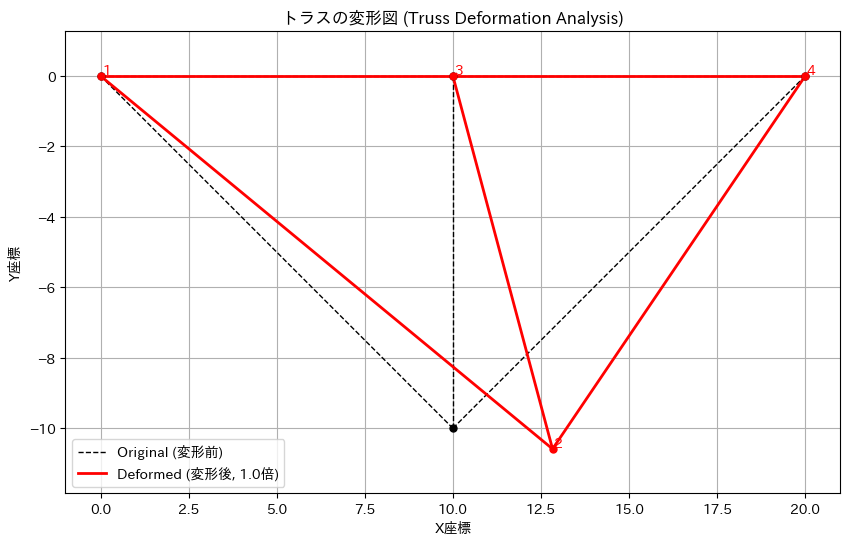

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib # Google Colabで日本語表示を有効化

def plot_truss(nodes, elements, U_all, scale_factor=1.0):
    """
    トラスの変形前と変形後を描画する関数 (可視化担当)

    Args:
        nodes (dict): 節点座標 {節点番号: (x, y)}
        elements (dict): 要素 {要素番号: (i端, j端)}
        U_all (np.array): 全変位ベクトル (解析結果)
        scale_factor (float): 変位の表示倍率
    """

    # 変形後の節点座標を計算
    nodes_deformed = {}
    for node_id, (x, y) in nodes.items():
        dof_x = (node_id - 1) * 2
        dof_y = (node_id - 1) * 2 + 1

        # 変位に変倍率を適用
        u = U_all[dof_x] * scale_factor
        v = U_all[dof_y] * scale_factor

        nodes_deformed[node_id] = (x + u, y + v)

    plt.figure(figsize=(10, 6))

    # 1. 変形前の構造を描画 (破線・黒)
    for el_id, (i, j) in elements.items():
        x = [nodes[i][0], nodes[j][0]]
        y = [nodes[i][1], nodes[j][1]]
        plt.plot(x, y, 'k--', linewidth=1.0, label='Original (変形前)' if el_id == 1 else "")

    # 2. 変形後の構造を描画 (実線・赤)
    for el_id, (i, j) in elements.items():
        x_def = [nodes_deformed[i][0], nodes_deformed[j][0]]
        y_def = [nodes_deformed[i][1], nodes_deformed[j][1]]
        plt.plot(x_def, y_def, 'r-', linewidth=2.0, label=f'Deformed (変形後, {scale_factor}倍)' if el_id == 1 else "")

    # 3. 節点を描画
    for node_id, (x, y) in nodes.items():
        plt.plot(x, y, 'ko', markersize=5) # 変形前の節点

    for node_id, (x_def, y_def) in nodes_deformed.items():
        plt.plot(x_def, y_def, 'ro', markersize=5) # 変形後の節点
        plt.text(x_def + 0.05, y_def + 0.05, f'{node_id}', color='red') # 節点番号


    plt.xlabel('X座標')
    plt.ylabel('Y座標')
    plt.title('トラスの変形図 (Truss Deformation Analysis)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal') # X軸とY軸のスケールを合わせる
    plt.show()


def solve_truss(nodes, elements, E, A, bcs, loads):
    """
    トラス構造解析を実行する関数 (計算担当)

    Args:
        nodes (dict): 節点座標
        elements (dict): 要素定義
        E (float): ヤング係数
        A (float): 断面積
        bcs (dict): 境界条件
        loads (dict): 荷重ベクトル

    Returns:
        U_all (np.array): 全変位ベクトル
        element_forces (dict): 要素ごとの軸力
    """

    # -----------------------------------------------------
    # 1. 入力データの確認 (メインから渡されたもの)
    # -----------------------------------------------------
    print("--- 1. 入力データ ---")
    print(f"節点: {nodes}")
    print(f"要素: {elements}")
    print(f"E={E}, A={A}")
    print(f"荷重: {loads}")
    print(f"境界条件: {bcs}\n")

    # -----------------------------------------------------
    # 2. 全体剛性行列 [K_all] の構築 (アセンブリ)
    # -----------------------------------------------------

    num_nodes = len(nodes)
    num_dofs = num_nodes * 2
    K_all = np.zeros((num_dofs, num_dofs))
    F_all = np.zeros(num_dofs)

    print("--- 2. 要素剛性行列の計算とアセンブリ ---")

    for el_id, (i, j) in elements.items():

        xi, yi = nodes[i]
        xj, yj = nodes[j]
        dx = xj - xi
        dy = yj - yi
        L = np.sqrt(dx**2 + dy**2)
        c = dx / L
        s = dy / L

        # 部材座標系の要素剛性行列 [k] (4x4)
        k_local = (E * A / L) * np.array([
            [ 1,  0, -1,  0],
            [ 0,  0,  0,  0],
            [-1,  0,  1,  0],
            [ 0,  0,  0,  0]
        ])

        # 座標変換マトリクス [R] (4x4)
        R_theta = np.array([
            [ c,  s],
            [-s,  c]
        ])
        R = np.zeros((4, 4))
        R[0:2, 0:2] = R_theta
        R[2:4, 2:4] = R_theta

        # [K'] = [R]^T [k] [R]
        K_global = R.T @ k_local @ R

        print(f"要素 {el_id} (節点 {i}-{j}): L={L:.2f}, c={c:.2f}, s={s:.2f}")

        # [K'] を [K_all] にアセンブリ
        dofs = [ (i-1)*2, (i-1)*2 + 1, (j-1)*2, (j-1)*2 + 1 ]
        for r in range(4):
            for col in range(4):
                K_all[dofs[r], dofs[col]] += K_global[r, col]

    for node_id, (Fx, Fy) in loads.items():
        F_all[(node_id-1)*2]     = Fx
        F_all[(node_id-1)*2 + 1] = Fy

    print(f"\nアセンブリ後の全体剛性行列 K_all ({num_dofs}x{num_dofs}):\n {np.round(K_all, 3)}")

    # -----------------------------------------------------
    # 3. 境界条件の適用と求解
    # -----------------------------------------------------

    free_dofs = []
    fixed_dofs = []
    for node_id, (x_fixed, y_fixed) in bcs.items():
        dof_x = (node_id - 1) * 2
        dof_y = (node_id - 1) * 2 + 1
        if x_fixed: fixed_dofs.append(dof_x)
        else: free_dofs.append(dof_x)
        if y_fixed: fixed_dofs.append(dof_y)
        else: free_dofs.append(dof_y)

    free_dofs.sort()
    K_ff = K_all[np.ix_(free_dofs, free_dofs)]
    F_f = F_all[free_dofs]

    print(f"\n--- 3. 境界条件の適用 ---")
    print(f"自由な自由度 (DOFs): {free_dofs}")
    print(f"解くべき部分剛性方程式 K_ff:\n {np.round(K_ff, 3)}")
    print(f"対応する荷重ベクトル F_f: {F_f}")

    # 連立方程式を解く
    try:
        U_f = np.linalg.solve(K_ff, F_f)
    except np.linalg.LinAlgError:
        print("エラー: 剛性行列が特異であり、解析できませんでした。")
        print("（拘束条件が不足していないか確認してください）")
        return None, None

    # -----------------------------------------------------
    # 4. 結果の整理 (変位)
    # -----------------------------------------------------

    U_all = np.zeros(num_dofs)
    U_all[free_dofs] = U_f

    print(f"\n--- 4. 解析結果 (変位) ---")
    for i in range(num_nodes):
        u = U_all[i*2]
        v = U_all[i*2 + 1]
        print(f"節点 {i+1}: U_{i+1} = {u: .7f}, V_{i+1} = {v: .7f}")

    # -----------------------------------------------------
    # 5. 【★追加コード】要素力の計算
    # -----------------------------------------------------
    print("\n--- 5. 解析結果 (部材軸力) ---")
    element_forces = {}

    for el_id, (i, j) in elements.items():

        # 要素の幾何情報を再計算 (L, c, s)
        xi, yi = nodes[i]; xj, yj = nodes[j]
        dx = xj - xi; dy = yj - yi; L = np.sqrt(dx**2 + dy**2)
        c = dx / L; s = dy / L

        # 節点i, jの変位を U_all から抽出
        u_i = U_all[(i-1)*2]; v_i = U_all[(i-1)*2 + 1]
        u_j = U_all[(j-1)*2]; v_j = U_all[(j-1)*2 + 1]

        # 全体座標系での変位ベクトル {u'}
        U_global = np.array([u_i, v_i, u_j, v_j])

        # 軸ひずみ成分（εx'）の計算に対応するマトリクス
        # [B] = 1/L * [-c -s c s]
        B_matrix = (1.0 / L) * np.array([-c, -s, c, s])

        # 部材軸力 N = E * A * (ひずみ ε) = E * A * [B] * {u'}
        N = E * A * (B_matrix @ U_global)

        element_forces[el_id] = N
        print(f"要素 {el_id} (節点 {i}-{j}): 軸力 N = {N: .7f} ({'引張' if N > 0 else '圧縮'})")

    return U_all, element_forces

# =====================================================
# メイン実行ブロック
# 【第05回 演習：不静定トラス】
# =====================================================

if __name__ == "__main__":

    # -----------------------------------------------------
    # 1. 解析条件の定義 (不静定トラス)
    # -----------------------------------------------------

    # 節点座標 {節点番号: (x, y)}
    nodes = {
        1: (0.0, 0.0),   # 節点1
        2: (, ), # 節点2
        3: (, ),  # 節点3
        4: (, )   # 節点4
    }

    # 要素の定義 {要素番号: (i端節点, j端節点)}
    elements = {
        1: (1, 2),  # 要素1
        2: (2, 3),  # 要素2
        3: (, ),  # 要素3
        4: (, ),  # 要素4
        5: (, )   # 要素5
    }

    # 材料・断面特性
    E = 1000.0  # ヤング係数
    A = 1.0     # 断面積 (EA = 1000)

    # 境界条件 {節点番号: (x拘束, y拘束)}
    bcs = {
        1: (True, True),   # 節点1 (ピン固定)
        2: (, ), # 節点2 (自由)
        3: (, ),   # 節点3 (ピン固定)
        4: (, )    # 節点4 (ピン固定)
    }

    # 荷重ベクトル {節点番号: (Fx, Fy)}
    loads = {
        1: (0.0, 0.0),
        2: (0.0, 0.0), # 節点2に (PX=200, PY=-100)
        3: (0.0, 0.0),
        4: (0.0, 0.0)
    }

    # 可視化のスケールファクタ（変位を何倍で描画するか）
    scale_factor = 1.0 # (変位が見やすいように調整)

    # -----------------------------------------------------
    # 2. 解析の実行
    # -----------------------------------------------------
    print("★★★ 第05回 演習（不静定トラス）モデルを解析します ★★★\n")

    # 関数を呼び出し、入力データを渡す
    U_result, Forces_result = solve_truss(nodes, elements, E, A, bcs, loads)

    # -----------------------------------------------------
    # 3. 可視化の実行
    # -----------------------------------------------------
    if U_result is not None:
        print(f"\n--- 6. 可視化 (変位を {scale_factor} 倍で表示) ---")
        plot_truss(nodes, elements, U_result, scale_factor=scale_factor)